# Stochastic Simulation Code

In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
rng= np.random.default_rng()

## Implemenation of the Gillespie Direct Method
Otherwise known as the stochastic simulation algorithm SSA

### Birth and Death Model
Deterministic approach:
$$
\frac{d\bar{X}}{dt} = \beta_s - k_{\emptyset} \bar{X}
$$

In doing so we will essentially "ignore" any microscopic behaviour and look at the reaction system at a "high level".

Discreet Stochastic Approach:

Concerned with observing how the state distribution varies over time, for example: with some initial condition what is the probability of finding the system in a particular state within the next X seconds/minutes/years


0. Set the time $t=0$, the initial species amounts $\mathbf{X}(0)=\mathbf{X}_0$ and compute the propensities $\mathbf{a}(0)$ and total propensity $a_{\mathrm{tot}}=\sum_{i=0}^N a_i$.

$$ \frac{dP_t}{dt} = a(t)P_t $$

We can write the time evolution of $p_i$ as
$$
\frac{dp_i}{dt}= \underbrace{\beta_s(p_{i-1} - p_i)}_{\textsf{synthesis}} 
                - \underbrace{k_{\emptyset}(i p_i - (i+1) p_{i+1})}_{\textsf{degradation}}
$$

1. Draw a random number $\rho_1=U(0,1)$ and determine the time of the next reaction as 
$$t_{\mathrm{next}}= t - \frac{\ln\rho_1}{a_{\mathrm{tot}}}.$$

2. Draw a random number $\rho_2=U(0,1)$ and determine the index of the next reaction as 
   $$ \textrm{smallest } j \textrm{ such that } \sum_{i=1}^j \frac{a_i}{a_{\mathrm{tot}}} > \rho_2$$

3. Set $t=t_{\mathrm{next}}$ and $\mathbf{X}(t_{\mathrm{next}})= \mathbf{X}(t) + \mathbf{S}_j$, where $\mathbf{S}_j$ is the $j$-th column of the stoichiometry matrix corresponding to reaction $j$.

4. Update $\mathbf{a}(t)$ and $a_{\mathrm{tot}}$. Goto step 1 unless maximum number of allowed steps is reached. 



In [61]:
# Model definition; this gives back the propensity of [birth, death]
def a_bd(x): 
    # Physical model of Living Systems - Nelson
    bs = 0.15  # Decay rate of Bs, in 1/min
    k0 = 0.014  # Growth rate constant, in 1/min
    return np.array([bs, k0 * x[0]])  # Simple model of Bs - k0 * x (described above in notes)

# Stoichiometric matrix for the reaction 
# There is only one row because there is only one species, X. 
# The first column represents birth, dictated by propensity Bs, and the second column represents death, dictated by propensity k0 * X.  
S_bd = np.array([[1, -1]])

# A function to run stochastic simulation.
# Initial condition: X0 is an array with a single element 0
# Reaction propensity function: prop depends on current X values 
# Stoichiometric matrix for the reaction: S represents how the X value changes based on which event is chosen
# maxsteps: Maximum number of simulation steps
# n_traj: Number of trajectories to simulate 
def run_ssa(X0, prop, S, maxsteps=1000, n_traj=10, rng=rng):
    # Arrays for storing trajectory events --> keep track of simulated time and X values
    t_arr = np.zeros((n_traj, maxsteps)) 
    X_arr = np.zeros((n_traj, maxsteps, len(X0)))

    for n in range(n_traj): 
        # Initialize simulation parameters for each trajectory
        t = 0
        X = X0.copy()
        a = prop(X)
        atot = sum(a)
        
        # Record initial state
        t_arr[n, 0] = 0.0
        X_arr[n, 0, :] = X[:]
        
        # Begin simulation
        for i in range(1, maxsteps):
            # Step 1: Calculate the time of the next event
            r1 = rng.random()
            t_next = t - np.log(r1) / atot
            
            # Step 2: Choose the reaction to occur based on propensities
            r2 = rng.random()
            asum = 0.0
            for j in range(len(a)):
                asum += a[j] / atot  # Relative propensity
                if asum > r2:
                    break
            j_next = j
            
            # Step 3: Update time and state according to the chosen reaction
            t = t_next
            X += S[:, j_next]
            
            # Record the time and state
            t_arr[n, i] = t
            X_arr[n, i, :] = X[:]
            
            # Step 4: Update propensities for the new state
            a = prop(X)
            atot = sum(a)

    return t_arr, X_arr



## Sample trajectories for the birth-death model

In [63]:
# Calling the run_ssa function to perform a stochastic simulation
t_arr, X_arr = run_ssa(np.array([0]), a_bd, S_bd, maxsteps=10, n_traj=1)

In [64]:
# Same thing, but now run it for 400 trajectories
t_arr, X_arr = run_ssa(np.array([0]), a_bd, S_bd, maxsteps=1000,n_traj=400)

## Plot trajectories using `matplotlib.pyplot.step`

Text(0, 0.5, 'number')

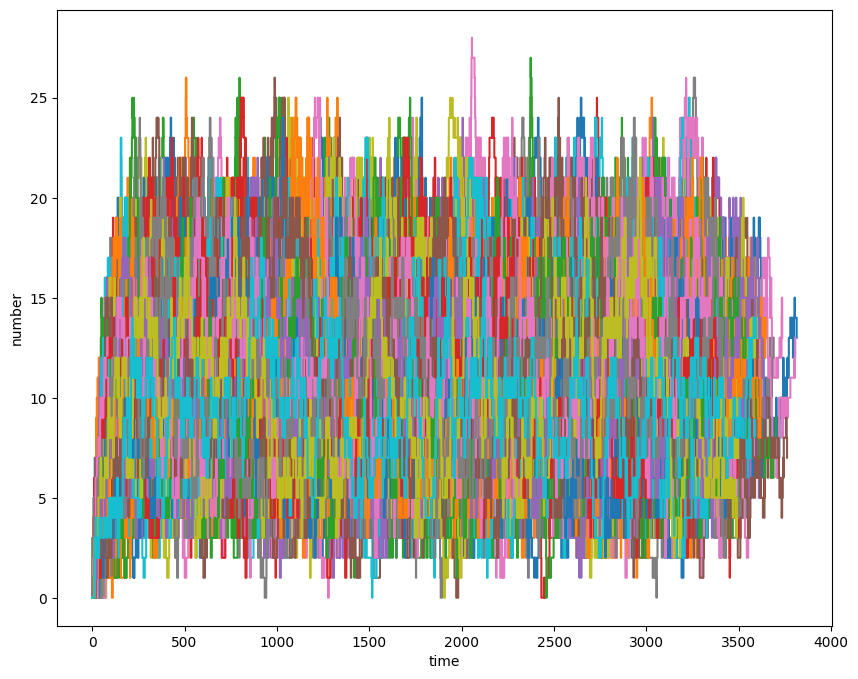

In [65]:
# Creating a new figure for the plot with a specific size
plt.figure(figsize=(10, 8))

# Iterating over each trajectory stored in t_arr and X_arr
for n in range(len(t_arr)):
    # Extracting time and state values for the current trajectory
    t = t_arr[n, :]
    x = X_arr[n, :, 0]

    # Plotting the trajectory using step function
    plt.step(t, x, '-', where='post')

# Adding labels to the plot
plt.xlabel('time')  # X-axis label
plt.ylabel('number')  # Y-axis label

# Optionally, you can uncomment and set specific limits for the x and y axes
# plt.xlim([0, 10])  # Set x-axis limits
# plt.ylim([0, 10])  # Set y-axis limits

# Display the plot

## Resample trajectories and compute averages

In [68]:
# Resample time series of unevenly spaced points on a new grid
def resample(t, y, tnew):
    # Determine the shape of the new data array
    snew = (len(tnew),) + y.shape[1:]
    
    # Initialize the new data array with zeros
    ynew = np.zeros(snew)
    
    # Initialize the index counter for the original time series
    ic = 0
    
    # Iterate over each point in the new time grid
    for i in range(len(tnew)):
        # Check if the current original time point is greater than the new time point
        if t[ic] > tnew[i]:
            # If so, use the value from the previous time point in the original data
            ynew[i] = y[max(ic - 1, 0)].copy()
        else:
            # If not, find the next time point in the original data
            for ip in range(ic + 1, len(t)):
                if t[ip] > tnew[i]:
                    break
            # Update the index counter
            ic = ip
            # Use the value from the time point in the original data just before the new time point
            ynew[i] = y[ic - 1].copy()
    
    # Return the resampled time series
    return tnew, ynew


In [69]:
# Generate a new evenly spaced time grid using linspace
tre = np.linspace(0, 3000, 1000)
# Alternatively, you can use a different time range, for example:
# tre = np.linspace(0, 20, 10)

# Initialize a new data array with zeros to store resampled trajectories
Xre = np.zeros((len(t_arr), len(tre), X_arr.shape[2]))

# Iterate over each trajectory stored in t_arr and X_arr
for n in range(len(t_arr)):
    # Resample the time series of the current trajectory onto the new time grid
    t, xre = resample(t_arr[n, :], X_arr[n], tre)
    
    # Store the resampled trajectory in the new data array
    Xre[n, :, :] = xre

# Get the shape of the resampled time array
shape_t_arr = t_arr.shape

t_arr.shape

(400, 1000)

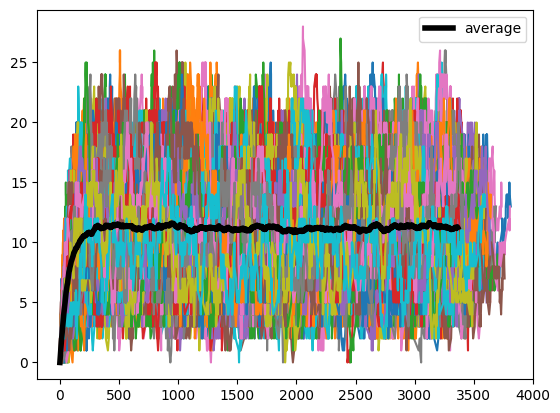

In [70]:
# Plot the original trajectories without resampling
for n in range(0, len(Xre), 1):
    plt.plot(t_arr[n], X_arr[n])

# Plot the average trajectory calculated across all trajectories
plt.plot(np.average(t_arr[:], axis=0), np.average(X_arr[:], axis=0), color='black', linewidth=4, label="average")

# Add a legend to the plot
plt.legend()


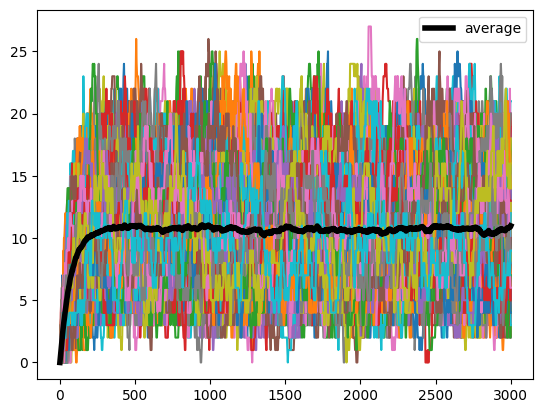

In [71]:
# Plot the resampled trajectories
for n in range(0, len(Xre), 1):
    plt.plot(tre, Xre[n])

# Plot the average resampled trajectory calculated across all trajectories
plt.plot(tre, np.average(Xre[:], axis=0), color='black', linewidth=4, label="average")

# Add a legend to the plot
plt.legend()

### Test to make sure that resampling is done correctly

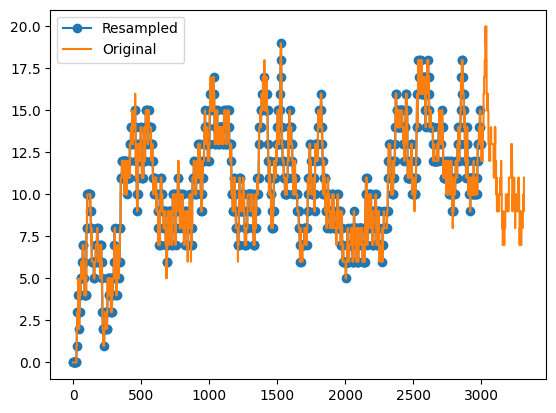

In [72]:
# Plot the resampled trajectory and the original trajectory for a specific dimension (here, the first dimension)
plt.plot(tre, Xre[0, :, 0], '-o', label='Resampled')  # Plot the resampled trajectory with markers
plt.step(t_arr[0, :], X_arr[0, :, 0], where="post", label='Original')  # Plot the original trajectory using step function

# Optionally, you can uncomment the line below to set specific limits for the x-axis
# plt.xlim([0, 100])

# Add a legend to the plot
plt.legend()


## Calculate expected steady state value of $X$ and compare with exact value

How many steps/trajectories do you need to compute to refute null hypothesis that they are the same?

In [73]:
# This is the same function that we ran in cell [4] 
t_arr, X_arr = run_ssa(np.array([0]), a_bd, S_bd, maxsteps=10000,n_traj=20)

In [74]:
# Calculate propensities for a specific state
a = a_bd([1])

# Calculate the exact expected value for the specific dimension
x_exact = a[0] / a[1]

# Calculate the residual of <X>, the average value of a specific dimension, at each trajectory
resid = (np.average(X_arr[:, 250:], axis=(1)).transpose() - x_exact).flatten()

# Print the residuals
print(resid)

# Calculate the mean of the residuals
average_residual = resid.sum() / len(resid)
print(average_residual)


[0.50591941 0.42489377 0.43720147 0.55063736 0.70756044 0.37627839
 0.727663   0.72848352 0.18632967 0.727663   0.41299634 0.17238095
 0.59638095 0.56602198 0.89402198 0.23556044 0.27863736 0.44827839
 0.58571429 0.91473993]
0.5238681318681327


There seems to be a small but significant discrepancy between the expected and actual average. What could be going on?

Notice that the total propensity and hence the waiting time distribution depends on $X$: 
$$ a_{\mathrm{tot}}= \beta_s + k_{\emptyset} X$$

So, we need to take the time average of $X$ to compare with the steady state value
$$ \left\langle X \right\rangle_t= \frac{1}{\tau}\int_0^{\tau} X(t) dt = 
   \frac{1}{\tau}\sum_{i=0}^{i_{\mathrm{max}}-1} X_i(t_{i+1}-t_i),$$
where $X_i$ is the value of $X$ at the $i$-th step that occurs at $t_i$ and which remains constant until the next step at $t_{i+1}$.

We can compute the time average in Python by taking applying `numpy.diff` to the time array:

In [75]:
# Calculate residuals using time differences
resid = np.sum(np.diff(t_arr[:, 250:]) * X_arr[:, 250:-1, 0], 1) / (t_arr[:, -1] - t_arr[:, 250]) - x_exact

# Print the residuals
print(resid)

# Calculate the mean of the residuals
average_residual = resid.sum() / len(resid)
print(average_residual)


[-0.06659284 -0.05069923  0.00136676  0.04029407  0.27959398 -0.11577611
  0.10886126  0.21224103 -0.31923932  0.18084081 -0.15232112 -0.41760679
  0.1168167   0.01667375  0.37973395 -0.25358748 -0.21346542 -0.06139682
  0.04283759  0.34385563]
0.003621519239068771


## Comparison of steady state distribution with Poisson
$$
p_{\ell} = \frac{e^{-\frac{\beta_s}{k_{\emptyset}}}}{\ell!}\left(\frac{\beta_s}{k_{\emptyset}}\right)^{\ell}
$$


In [76]:
# For steady state properties we can simulate with one long trajectory. To avoid burnin, we'll start with
# X0=10
t_arr, X_arr = run_ssa(np.array([10]), a_bd, S_bd, maxsteps=1000000,n_traj=1)


### Make sure to resample first

In [77]:
# Generate a new evenly spaced time grid using linspace
tre = np.linspace(0, t_arr[0, -1], 100000)

# Resample the trajectory onto the new time grid
t, xre = resample(t_arr[0, :], X_arr[0], tre)

# Print the averages of the original trajectory, resampled trajectory, and the expected value
print(np.average(X_arr), np.average(xre), x_exact)


11.222534 10.73043 10.714285714285714


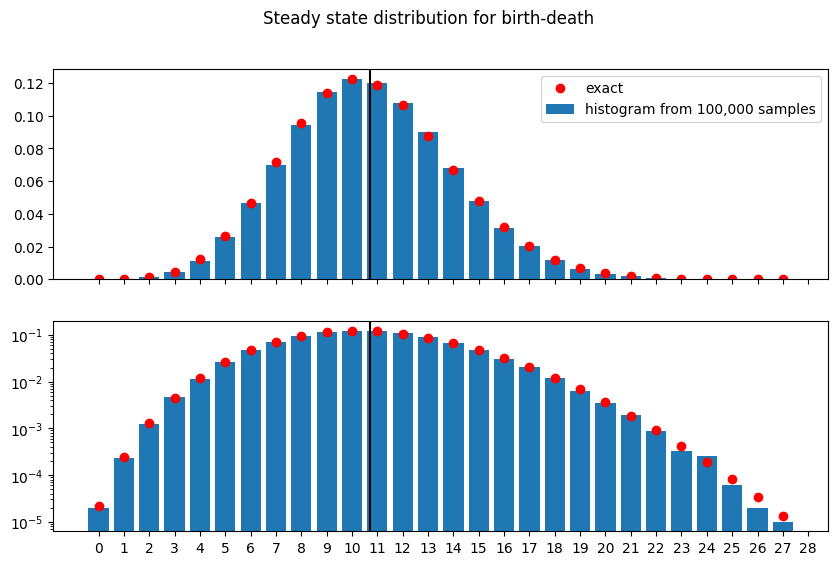

In [78]:
from scipy.stats import poisson as pp

# Define bins for the histogram
bins = np.arange(0, xre.max() + 1.5) - 0.5

# Compute the histogram and bin edges
hist, bins = np.histogram(xre, bins, density=True)
bvals = bins[:-1] + 0.5

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# Set the main title for the entire figure
fig.suptitle('Steady state distribution for birth-death')

# Plot on the first subplot with a linear y-axis scale
ax[0].set_xticks(bins + 0.5)
ax[0].plot(bvals, pp.pmf(bvals, mu=x_exact), 'ro', label='exact')
ax[0].bar(bvals, hist, label=f'histogram from 100,000 samples')
ax[0].axvline(x_exact, color='black')  # Vertical line at the expected value
ax[0].legend()

# Plot on the second subplot with a logarithmic y-axis scale
ax[1].semilogy(bvals, pp.pmf(bvals, mu=x_exact), 'ro')
ax[1].bar(bvals, hist)
_ = ax[1].axvline(x_exact, color='black')  # Vertical line at the expected value

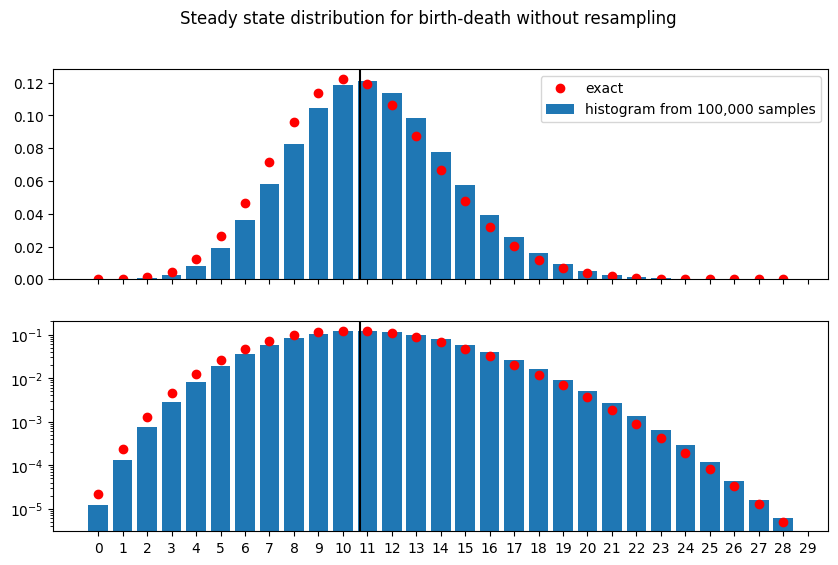

In [79]:
# Define bins for the histogram
bins = np.arange(0, X_arr[0].max() + 1.5) - 0.5

# Compute the histogram and bin edges for the original trajectory without resampling
hist, bins = np.histogram(X_arr[0], bins, density=True)
bvals = bins[:-1] + 0.5

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# Set the main title for the entire figure
fig.suptitle('Steady state distribution for birth-death without resampling')

# Plot on the first subplot with a linear y-axis scale
ax[0].set_xticks(bins + 0.5)
ax[0].plot(bvals, pp.pmf(bvals, mu=x_exact), 'ro', label='exact')
ax[0].bar(bvals, hist, label=f'histogram from 100,000 samples')
ax[0].axvline(x_exact, color='black')  # Vertical line at the expected value
ax[0].legend()

# Plot on the second subplot with a logarithmic y-axis scale
ax[1].semilogy(bvals, pp.pmf(bvals, mu=x_exact), 'ro')
ax[1].bar(bvals, hist)
_ = ax[1].axvline(x_exact, color='black')  # Vertical line at the expected value

## Comparison of average trajectory with deterministic limit

In [80]:
def f_bd(t, x):
    # Setting up the ODE by performing matrix-vector multiplication
    # S_bd is the stoichiometric matrix, and a_bd(x) represents the reaction propensities
    return np.matmul(S_bd, a_bd(x))

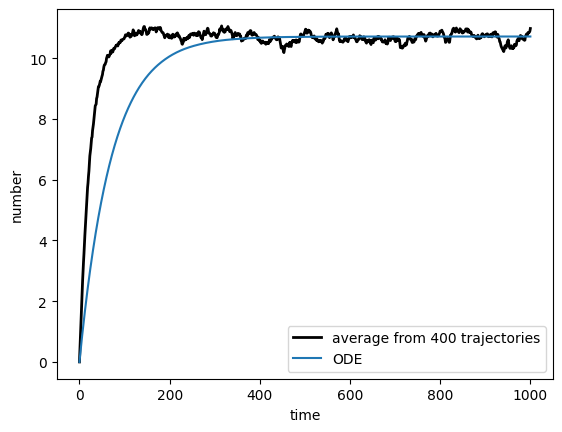

In [81]:
from scipy.integrate import solve_ivp

# Define the maximum time, number of points, and time points for evaluation
tmax = 1000
npts = 1000
tint = np.linspace(0, tmax, npts)

# Solve the ODE using solve_ivp
sol = solve_ivp(f_bd, [0, tmax], [0.0], t_eval=tint)

# Plot the average trajectory from resampling
lab = f'average from {len(Xre)} trajectories'
plt.plot(tint, np.average(Xre[:, :, 0], axis=0), color='black', linewidth=2, label=lab)

# Plot the ODE solution
plt.plot(sol.t, sol.y[0], label='ODE')  # Access the first component of sol.y

# Add labels and legend to the plot
plt.xlabel('time')
plt.ylabel('number')
_ = plt.legend()
